# AML — Task 1
## Predict the age of a brain from MRI features
---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from pandas_profiling import ProfileReport

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor

---
## Function definition

---
### Load datasets

In [3]:
def load_raw_data():
    X_train = pd.read_csv('data/X_train.csv').drop(columns=['id'])
    y_train = pd.read_csv('data/y_train.csv').drop(columns=['id'])
    X_test = pd.read_csv('data/X_test.csv').drop(columns=['id'])
    return X_train, y_train, X_test

---
### Export datasets

In [4]:
def export_to_csv(X_train_cleaned, y_train_cleaned, X_test_cleaned):
    X_train_cleaned.to_csv('data/X_train_cleaned.csv', index=False)
    y_train_cleaned.to_csv('data/y_train_cleaned.csv', index=False)
    X_test_cleaned.to_csv('data/X_test_cleaned.csv', index=False)

---
### Outlier detection

In [5]:
def remove_outliers(X_train, y_train, contamination='auto', verbose=1):
    """
    Remove the ouliers from our dataset. Temporarily replace the nan values by 
    the median to perform the outlier detection.

    Parameters
    ----------
    X_train : pd.df
        The features (what we will use to see the outliers)
    y_train : pd.df
        The labels
    contamination : int, optional
        The percent of outliers found by the isolation forest if it is used.

    Return
    ------
    (pd.df, pd.df)
        The data with the outliers rows removed
    """
    # Save a mask of the imputed values to be able to redo the imputation once the outlier detection is done
    X_train_null_mask = X_train.isna()
    
    # Need to impute nan values for the outlier detection to work (cannot deal with nan)
    X_train_imputed = pd.DataFrame(SimpleImputer(strategy="median", verbose=verbose).fit_transform(X_train))
    
#     clf = IsolationForest(contamination=contamination, random_state=0) # modify here
    clf = LocalOutlierFactor(contamination=contamination) # modify here
    outliers_mask = pd.Series(clf.fit_predict(X_train_imputed))
    
    if verbose:
        print(f"Detected {(outliers_mask == -1).sum()} outliers, out of {outliers_mask.shape[0]} samples ({100 * (outliers_mask == -1).sum() / outliers_mask.shape[0]:.2f}%).")
    
    # Put back the nan values
    # convert the null mask to np.array so it is correctly applied since X_train indexes have changed
    X_train_no_outliers = X_train_imputed.mask(np.array(X_train_null_mask))
    
    # Remove outliers from the training set
    X_train_no_outliers = X_train_no_outliers.loc[outliers_mask == 1, :]
    y_train_no_outliers = y_train.loc[outliers_mask == 1, :]
    
    return (X_train_no_outliers, y_train_no_outliers)

---
### Data scaling
Should be done as soon as possible because can have an effect (e.g. on distances for `KNNImputer`)

In [6]:
def scale(X_train, X_test):
    # Do the scaling, saving the scaler to use it for X_test too. No need for imputation, just ignore nan values.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train))
    # Cast X_test to np.array to avoid warning of model trained without feature names but X having some.
    X_test_scaled = pd.DataFrame(scaler.transform(np.array(X_test)))
    return (X_train_scaled, X_test_scaled)

---
### Imputation of values

In [17]:
def impute_values(X_train, X_test, method='knn', max_iter=15):
    print(f"For the train dataset, there are {np.array(X_train.isna()).sum().sum()} nan values, out of {X_train.shape[0]*X_train.shape[1]} ({100*np.array(X_train.isna()).sum().sum()/(X_train.shape[0]*X_train.shape[1]):.2f}%).")
    
    imputer = None
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=6, weights='uniform').fit(X_train)
    elif method == 'iterative':
        # Runs VERY slowly
        imputer = IterativeImputer(random_state=0, max_iter=max_iter, verbose=2).fit(X_train)
    
    X_train_imputed = pd.DataFrame(imputer.transform(X_train))
    X_test_imputed = pd.DataFrame(imputer.transform(X_test))
    return (X_train_imputed, X_test_imputed)

---
### Feature selection

In [8]:
def select_features(X_train, y_train, X_test):
    X_train_selected_features, X_test_selected_features = remove_constant_features(X_train, X_test)
    X_train_selected_features, X_test_selected_features = remove_too_correlated_features(X_train_selected_features, X_test_selected_features)
    X_train_selected_features, X_test_selected_features = remove_random_features(X_train_selected_features, y_train, X_test_selected_features, percentile=80)
    
    return X_train_selected_features, X_test_selected_features

In [9]:
def remove_constant_features(X_train, X_test, verbose=1):
    X_train_selected_features = X_train.loc[:, (X_train != X_train.iloc[0]).any()]
    X_test_selected_features = X_test.loc[:, (X_train != X_train.iloc[0]).any()]
    
    if verbose:
        print(f"{X_train.shape[1]-X_train_selected_features.shape[1]} features removed because of constant values ({100*(X_train.shape[1]-X_train_selected_features.shape[1])/X_train.shape[1]:.2f}%).")
    
    return X_train_selected_features, X_test_selected_features

In [10]:
def remove_too_correlated_features(X_train, X_test, threshold=0.7, verbose=1):
    X_train_corr_ = X_train.corr()

    X_train_too_correlated = (X_train_corr_.mask(
        np.tril(np.ones([len(X_train_corr_)]*2, dtype=bool))).abs() > threshold).any()
    
    X_train_selected_features = X_train.loc[:, (~X_train_too_correlated)]
    X_test_selected_features = X_test.loc[:, (~X_train_too_correlated)]
    
    if verbose:
        print(f"{X_train.shape[1]-X_train_selected_features.shape[1]} features removed because of correlation with another feature > {threshold} ({100*(X_train.shape[1]-X_train_selected_features.shape[1])/X_train.shape[1]:.2f}%).")

    return X_train_selected_features, X_test_selected_features

In [11]:
def remove_random_features(X_train, y_train, X_test, Xtrm=None, Xtem=None, k=190, verbose=1):
    selector = SelectKBest(f_regression, k=k) # modify here
    selector.fit(X_train, np.array(y_train).ravel())
    X_train_selected_features = pd.DataFrame(selector.transform(X_train))
    X_test_selected_features = pd.DataFrame(selector.transform(X_test))
    if Xtrm is not None:
        Xtrm = pd.DataFrame(selector.transform(Xtrm))
    if Xtem is not None:
        Xtem = pd.DataFrame(selector.transform(Xtem))
    
    if verbose:
        print(f"{X_train.shape[1]-X_train_selected_features.shape[1]} features removed because of low correlation with target ({100*(X_train.shape[1]-X_train_selected_features.shape[1])/X_train.shape[1]:.2f}%).")
        
    return X_train_selected_features, X_test_selected_features, Xtrm, Xtem

---
### Models

In [12]:
def best_lasso(X_train, y_train):
    lasso = Lasso(max_iter=100000)
    gs_lasso_params = {
        'alpha': np.logspace(-2, 0, 20),
    }
    gs_lasso = GridSearchCV(lasso, gs_lasso_params, cv=5, verbose=3)
    gs_lasso.fit(X_train, y_train)
    
    print(f"The best validation score obtained is {gs_lasso.best_score_:.5f} with\n\talpha: {gs_lasso.best_params_['alpha']}")
    
    return gs_lasso

In [25]:
def best_svr(X_train, y_train):
    svr = SVR()
    gs_svr_params = {
        'kernel': ['rbf'],#, 'poly', 'sigmoid'],
        'C': np.logspace(0, 3, 6),
        'epsilon': np.logspace(-4, -1, 7),
    }
    gs_svr = GridSearchCV(svr, gs_svr_params, cv=5, verbose=3)
    gs_svr.fit(X_train, y_train)
    
    print(f"""The best validation score obtained is {gs_svr.best_score_:.5f} with
    \tkernel: {gs_svr.best_params_['kernel']}
    \tC: {gs_svr.best_params_['C']}
    \tepsilon: {gs_svr.best_params_['epsilon']}""")
    
    return gs_svr

In [14]:
def best_gbr(X_train, y_train):
#     gbr = GradientBoostingRegressor(random_state=0)
#     gs_gbr_params = {
#         "learning_rate": np.logspace(-3, -1, 3),
#         "n_estimators": np.logspace(1, 3, 3),
#         "subsample": [0.7, 1],
#         "max_depth": [3, 4, 5],
#     }
#     gs_gbr = GridSearchCV(gbr, gs_gbr_params, cv=5, verbose=3, error_score='raise')
#     gs_gbr.fit(X_train, y_train)
#     return gs_gbr

    params = {
        "loss": "squared_error",
        "n_estimators": 250,
        "learning_rate": 0.025,
        "subsample": 0.75,
        "max_depth": 6,
        "min_samples_split": 5,
        "n_iter_no_change": 100,
        "validation_fraction": 0.1,
        "random_state": 0, 
        "verbose": 1,
    }

    gbr = GradientBoostingRegressor(**params)
    
    # Get the validation score
    gbr_cv_scores = cross_val_score(gbr, X_train, y_train, n_jobs=-1, verbose=3)
    print(f"""Validation score obtained is {np.mean(gbr_cv_scores):.4f} with
    \t{params}""")
    
    # Fit model (because previous function does not return fitted model)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    gbr.fit(X_train, y_train)
    
    test_score = np.zeros(gbr.n_estimators_, dtype=np.float64)
    for i, y_pred in enumerate(gbr.staged_predict(X_test)):
        test_score[i] = gbr.loss_(y_test, y_pred)

    fig = plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.title("Deviance")
    plt.plot(
        np.arange(gbr.n_estimators_),
        gbr.train_score_,
        "b-",
        label="Training Set Deviance",
    )
    plt.plot(
        np.arange(gbr.n_estimators_), test_score, "r-", label="Test Set Deviance"
    )
    plt.legend(loc="upper right")
    plt.xlabel("Boosting Iterations")
    plt.ylabel("Deviance")
    fig.tight_layout()
    plt.show()
    
    return gbr

---
### Submission file

In [15]:
def create_submission(prediction, sub_id, basepath='submissions/task1-sub'):
    result = prediction.copy()
    result = result.rename(columns={0: 'y'})
    result['id'] = range(0, len(result))
    result = result[['id', 'y']]
    result.to_csv(basepath + str(sub_id) + '.csv', index=False)

---
## Run pipeline

---
### Data preprocessing

In [16]:
# print("Loading raw data...")
# X_train, y_train, X_test = load_raw_data()

# print("Removing outliers...")
# X_train_no_outliers, y_train_no_outliers = remove_outliers(X_train, y_train)

# print("Scaling data...")
# X_train_scaled, X_test_scaled = scale(X_train_no_outliers, X_test)

# print("Imputing nan values...")
# X_train_imputed, X_test_imputed = impute_values(X_train_scaled, X_test_scaled, method=knn')

# print("Selecting features...")
# X_train_selected_features, X_test_selected_features = select_features(X_train_imputed, y_train_no_outliers, X_test_imputed)

# print("Exporting clean data to csv...")
# X_train_cleaned, y_train_cleaned, X_test_cleaned = X_train_selected_features, y_train_no_outliers, X_test_selected_features
# export_to_csv(X_train_cleaned, y_train_cleaned, X_test_cleaned)

# print("All done!")

In [18]:
print("Loading raw data...")
X_train, y_train, X_test = load_raw_data()

print("Removing outliers...")
X_train, y_train = remove_outliers(X_train, y_train)

print("Scaling data...")
X_train, X_test = scale(X_train, X_test)

print("Selecting features...")
X_train, X_test = remove_constant_features(X_train, X_test)
X_train, X_test = remove_too_correlated_features(X_train, X_test, threshold=0.98)

#TODO: Clean pipeline
# If we want iterative imputation, and don't want to run it for one hour (should try at one point though), need to
# do feature selection before we do imputation. Except biggest filter for feature selection is f_regression which
# cannot deal with nan values. Therefore, intermediary dumb knn imputation was quickly/dirtily 
# implemented to see results.
# Conclusion: we achieve ~same or better validation scores with a LOT less features, seems like an 
# interresting way forward (even though test scores are a bit lower once submitted, but to not 
# overfit on the public ones and fail on the secret ones, should only watch validation score)
X_train_mask = X_train.isna()
X_test_mask = X_test.isna()
X_train, X_test = impute_values(X_train, X_test, method='knn')
X_train, X_test, X_train_mask, X_test_mask = remove_random_features(X_train, 
                                                                    y_train, 
                                                                    X_test, 
                                                                    Xtrm=X_train_mask, 
                                                                    Xtem=X_test_mask,
                                                                    k=190)
X_train = X_train.mask(np.array(X_train_mask))
X_test = X_test.mask(np.array(X_test_mask))

print("Imputing nan values...")
X_train, X_test = impute_values(X_train, X_test, method='iterative', max_iter=50)

print("Exporting clean data to csv...")
export_to_csv(X_train, y_train, X_test)

print("All done!")

Loading raw data...
Removing outliers...
Detected 50 outliers, out of 1212 samples (4.13%).
Scaling data...
Selecting features...
0 features removed because of constant values (0.00%).
35 features removed because of correlation with another feature > 0.98 (4.21%).
For the train dataset, there are 70627 nan values, out of 926114 (7.63%).


/Users/antoine/miniconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


607 features removed because of low correlation with target (76.16%).
Imputing nan values...
For the train dataset, there are 16827 nan values, out of 220780 (7.62%).
[IterativeImputer] Completing matrix with shape (1162, 190)
[IterativeImputer] Ending imputation round 1/50, elapsed time 4.33
[IterativeImputer] Change: 48.150001935452266, scaled tolerance: 0.013896992902987433 
[IterativeImputer] Ending imputation round 2/50, elapsed time 8.41
[IterativeImputer] Change: 4.925827540587253, scaled tolerance: 0.013896992902987433 
[IterativeImputer] Ending imputation round 3/50, elapsed time 12.38
[IterativeImputer] Change: 5.074170267817152, scaled tolerance: 0.013896992902987433 
[IterativeImputer] Ending imputation round 4/50, elapsed time 16.37
[IterativeImputer] Change: 1.5202463930482413, scaled tolerance: 0.013896992902987433 
[IterativeImputer] Ending imputation round 5/50, elapsed time 20.29
[IterativeImputer] Change: 0.5267513666383655, scaled tolerance: 0.013896992902987433 
[I

/Users/antoine/miniconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Ending imputation round 2/50, elapsed time 0.20
[IterativeImputer] Ending imputation round 3/50, elapsed time 0.30
[IterativeImputer] Ending imputation round 4/50, elapsed time 0.37
[IterativeImputer] Ending imputation round 5/50, elapsed time 0.45
[IterativeImputer] Ending imputation round 6/50, elapsed time 0.53
[IterativeImputer] Ending imputation round 7/50, elapsed time 0.60
[IterativeImputer] Ending imputation round 8/50, elapsed time 0.70
[IterativeImputer] Ending imputation round 9/50, elapsed time 0.78
[IterativeImputer] Ending imputation round 10/50, elapsed time 0.86
[IterativeImputer] Ending imputation round 11/50, elapsed time 0.95
[IterativeImputer] Ending imputation round 12/50, elapsed time 1.02
[IterativeImputer] Ending imputation round 13/50, elapsed time 1.09
[IterativeImputer] Ending imputation round 14/50, elapsed time 1.21
[IterativeImputer] Ending imputation round 15/50, elapsed time 1.31
[IterativeImputer] Ending imputation round 16/50, elapse

---
### Model training

In [19]:
lasso = best_lasso(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........................alpha=0.01;, score=0.519 total time=   0.3s
[CV 2/5] END ........................alpha=0.01;, score=0.533 total time=   0.3s
[CV 3/5] END ........................alpha=0.01;, score=0.410 total time=   0.2s
[CV 4/5] END ........................alpha=0.01;, score=0.564 total time=   0.4s
[CV 5/5] END ........................alpha=0.01;, score=0.401 total time=   0.2s
[CV 1/5] END ........alpha=0.012742749857031334;, score=0.520 total time=   0.3s
[CV 2/5] END ........alpha=0.012742749857031334;, score=0.535 total time=   0.4s
[CV 3/5] END ........alpha=0.012742749857031334;, score=0.415 total time=   0.2s
[CV 4/5] END ........alpha=0.012742749857031334;, score=0.566 total time=   0.3s
[CV 5/5] END ........alpha=0.012742749857031334;, score=0.404 total time=   0.2s
[CV 1/5] END ........alpha=0.016237767391887217;, score=0.522 total time=   0.2s
[CV 2/5] END ........alpha=0.016237767391887217

In [26]:
svr = best_svr(X_train, np.array(y_train).ravel())

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END .C=1.0, epsilon=0.0001, kernel=rbf;, score=0.511 total time=   0.1s
[CV 2/5] END .C=1.0, epsilon=0.0001, kernel=rbf;, score=0.469 total time=   0.1s
[CV 3/5] END .C=1.0, epsilon=0.0001, kernel=rbf;, score=0.447 total time=   0.1s
[CV 4/5] END .C=1.0, epsilon=0.0001, kernel=rbf;, score=0.458 total time=   0.1s
[CV 5/5] END .C=1.0, epsilon=0.0001, kernel=rbf;, score=0.470 total time=   0.1s
[CV 1/5] END C=1.0, epsilon=0.00031622776601683794, kernel=rbf;, score=0.511 total time=   0.1s
[CV 2/5] END C=1.0, epsilon=0.00031622776601683794, kernel=rbf;, score=0.469 total time=   0.1s
[CV 3/5] END C=1.0, epsilon=0.00031622776601683794, kernel=rbf;, score=0.447 total time=   0.1s
[CV 4/5] END C=1.0, epsilon=0.00031622776601683794, kernel=rbf;, score=0.458 total time=   0.1s
[CV 5/5] END C=1.0, epsilon=0.00031622776601683794, kernel=rbf;, score=0.470 total time=   0.1s
[CV 1/5] END ..C=1.0, epsilon=0.001, kernel=rbf;, sco

[CV 3/5] END C=15.848931924611133, epsilon=0.0031622776601683794, kernel=rbf;, score=0.596 total time=   0.2s
[CV 4/5] END C=15.848931924611133, epsilon=0.0031622776601683794, kernel=rbf;, score=0.627 total time=   0.2s
[CV 5/5] END C=15.848931924611133, epsilon=0.0031622776601683794, kernel=rbf;, score=0.650 total time=   0.2s
[CV 1/5] END C=15.848931924611133, epsilon=0.01, kernel=rbf;, score=0.739 total time=   0.2s
[CV 2/5] END C=15.848931924611133, epsilon=0.01, kernel=rbf;, score=0.649 total time=   0.2s
[CV 3/5] END C=15.848931924611133, epsilon=0.01, kernel=rbf;, score=0.596 total time=   0.2s
[CV 4/5] END C=15.848931924611133, epsilon=0.01, kernel=rbf;, score=0.627 total time=   0.2s
[CV 5/5] END C=15.848931924611133, epsilon=0.01, kernel=rbf;, score=0.650 total time=   0.2s
[CV 1/5] END C=15.848931924611133, epsilon=0.03162277660168379, kernel=rbf;, score=0.739 total time=   0.2s
[CV 2/5] END C=15.848931924611133, epsilon=0.03162277660168379, kernel=rbf;, score=0.649 total ti

[CV 1/5] END C=251.18864315095797, epsilon=0.1, kernel=rbf;, score=0.709 total time=   0.2s
[CV 2/5] END C=251.18864315095797, epsilon=0.1, kernel=rbf;, score=0.670 total time=   0.2s
[CV 3/5] END C=251.18864315095797, epsilon=0.1, kernel=rbf;, score=0.580 total time=   0.2s
[CV 4/5] END C=251.18864315095797, epsilon=0.1, kernel=rbf;, score=0.656 total time=   0.2s
[CV 5/5] END C=251.18864315095797, epsilon=0.1, kernel=rbf;, score=0.654 total time=   0.2s
[CV 1/5] END C=1000.0, epsilon=0.0001, kernel=rbf;, score=0.665 total time=   0.2s
[CV 2/5] END C=1000.0, epsilon=0.0001, kernel=rbf;, score=0.571 total time=   0.2s
[CV 3/5] END C=1000.0, epsilon=0.0001, kernel=rbf;, score=0.580 total time=   0.2s
[CV 4/5] END C=1000.0, epsilon=0.0001, kernel=rbf;, score=0.602 total time=   0.2s
[CV 5/5] END C=1000.0, epsilon=0.0001, kernel=rbf;, score=0.643 total time=   0.2s
[CV 1/5] END C=1000.0, epsilon=0.00031622776601683794, kernel=rbf;, score=0.665 total time=   0.2s
[CV 2/5] END C=1000.0, eps

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.8s remaining:   35.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.2s finished


Validation score obtained is 0.6257 with
    	{'loss': 'squared_error', 'n_estimators': 250, 'learning_rate': 0.025, 'subsample': 0.75, 'max_depth': 6, 'min_samples_split': 5, 'n_iter_no_change': 100, 'validation_fraction': 0.1, 'random_state': 0, 'verbose': 1}
      Iter       Train Loss      OOB Improve   Remaining Time 
         1          91.4967           2.6243           11.68s
         2          90.5996           2.8858           11.41s
         3          87.2881           2.3958           11.71s
         4          84.5777           1.8091           11.39s
         5          80.8859           1.9069           11.54s
         6          77.3343           1.9195           11.38s
         7          77.5435           1.7732           11.53s
         8          73.5253           1.9971           11.46s
         9          72.4122           1.6186           11.32s
        10          69.3160           1.4799           11.38s
        20          49.2331           0.7990           

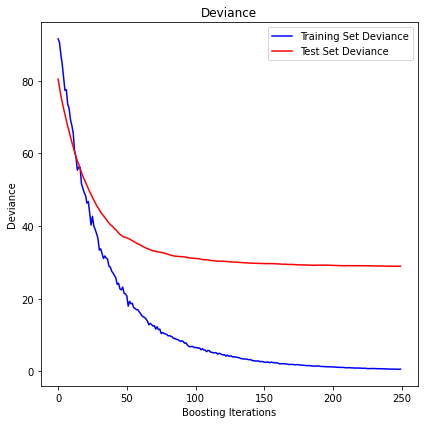

In [21]:
#TODO: could not manage to get grid search to work with this, should look into it as there are a lot of
# hyperparameters at play
gbr = best_gbr(X_train, np.array(y_train).ravel())

In [39]:
def best_Adaboost(X_train, y_train):
    
    ada = AdaBoostRegressor()
    gs_ada_params = {
     "loss":["square"],
     "learning_rate": np.logspace(-2, -1, 4),
     "n_estimators": np.arange(50, 250, 100),
     "random_state": [0], 
    }
    gs_ada = GridSearchCV(ada, gs_ada_params, cv=5, verbose=3, error_score='raise')
    gs_ada.fit(X_train, y_train)

    print(f"""The best validation score obtained is {gs_ada.best_score_:.5f} with
    \tloss: {gs_ada.best_params_['loss']}
    \tlearning_rate: {gs_ada.best_params_['learning_rate']}
    \tn_estimators: {gs_ada.best_params_['n_estimators']}
    """)
    
    return ada

In [40]:
ada = best_Adaboost(X_train, np.array(y_train).ravel())

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END learning_rate=0.01, loss=square, n_estimators=50, random_state=0;, score=0.488 total time=   1.9s
[CV 2/5] END learning_rate=0.01, loss=square, n_estimators=50, random_state=0;, score=0.466 total time=   1.7s
[CV 3/5] END learning_rate=0.01, loss=square, n_estimators=50, random_state=0;, score=0.429 total time=   1.7s
[CV 4/5] END learning_rate=0.01, loss=square, n_estimators=50, random_state=0;, score=0.533 total time=   1.7s
[CV 5/5] END learning_rate=0.01, loss=square, n_estimators=50, random_state=0;, score=0.455 total time=   1.7s
[CV 1/5] END learning_rate=0.01, loss=square, n_estimators=150, random_state=0;, score=0.508 total time=   5.3s
[CV 2/5] END learning_rate=0.01, loss=square, n_estimators=150, random_state=0;, score=0.460 total time=   5.0s
[CV 3/5] END learning_rate=0.01, loss=square, n_estimators=150, random_state=0;, score=0.468 total time=   5.1s
[CV 4/5] END learning_rate=0.01, loss=square, n_e

In [37]:
def best_random_forest(X_train, y_train):
    # define used regressor
    forest=RandomForestRegressor(n_estimators=20,
                                 max_depth=10,
                                 criterion='mse',)

    r_forest = RandomForestRegressor()
    gs_forest_params = {
     "n_estimators": np.arange(50, 100, 50),
     "max_depth": np.arange(2, 8, 2),
     "min_samples_split": np.arange(2, 8, 2),
     "min_samples_leaf": np.arange(1, 9, 3),
     "random_state": [0], 
     "verbose": [1]
    }
    
    gs_forest = GridSearchCV(r_forest, gs_forest_params, cv=5, verbose=3, error_score='raise')
    gs_forest.fit(X_train, y_train)
    

    print(f"""The best validation score obtained is {gs_forest.best_score_:.5f} with
    \tn_estimators: {gs_forest.best_params_['n_estimators']}
    \tmax_depth: {gs_forest.best_params_['max_depth']}
    \tmin_samples_split: {gs_forest.best_params_['min_samples_split']}
    \tmin_samples_leaf: {gs_forest.best_params_['min_samples_leaf']}
    """)
    
    return r_forest

In [38]:
rf = best_random_forest(X_train, np.array(y_train).ravel())

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.440 total time=   0.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.435 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.376 total time=   0.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.479 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.421 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.440 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.435 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.376 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.479 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.421 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=2, min_samples_leaf=1, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.440 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=2, min_samples_leaf=1, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.435 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=2, min_samples_leaf=1, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.376 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=2, min_samples_leaf=1, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.479 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=2, min_samples_leaf=1, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.421 total time=   0.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.440 total time=   1.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.435 total time=   1.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.376 total time=   1.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.479 total time=   0.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.421 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=2, min_samples_leaf=4, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.440 total time=   0.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=2, min_samples_leaf=4, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.435 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=2, min_samples_leaf=4, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.376 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=2, min_samples_leaf=4, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.479 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=2, min_samples_leaf=4, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.421 total time=   0.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=2, min_samples_leaf=4, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.440 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=2, min_samples_leaf=4, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.435 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=2, min_samples_leaf=4, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.376 total time=   1.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=2, min_samples_leaf=4, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.479 total time=   0.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=2, min_samples_leaf=4, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.421 total time=   0.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=2, min_samples_leaf=7, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.439 total time=   1.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=2, min_samples_leaf=7, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.436 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=2, min_samples_leaf=7, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.376 total time=   0.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=2, min_samples_leaf=7, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.479 total time=   1.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=2, min_samples_leaf=7, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.421 total time=   0.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=2, min_samples_leaf=7, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.439 total time=   1.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=2, min_samples_leaf=7, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.436 total time=   0.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=2, min_samples_leaf=7, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.376 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=2, min_samples_leaf=7, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.479 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=2, min_samples_leaf=7, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.421 total time=   0.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=2, min_samples_leaf=7, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.439 total time=   0.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=2, min_samples_leaf=7, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.436 total time=   0.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=2, min_samples_leaf=7, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.376 total time=   0.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=2, min_samples_leaf=7, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.479 total time=   1.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=2, min_samples_leaf=7, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.421 total time=   0.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.538 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.517 total time=   1.7s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.511 total time=   1.7s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.531 total time=   1.7s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.518 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.539 total time=   1.7s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.520 total time=   1.7s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.513 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.531 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.518 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=4, min_samples_leaf=1, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.539 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=4, min_samples_leaf=1, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.518 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=4, min_samples_leaf=1, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.510 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=4, min_samples_leaf=1, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.532 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=4, min_samples_leaf=1, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.519 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=4, min_samples_leaf=4, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.554 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=4, min_samples_leaf=4, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.527 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=4, min_samples_leaf=4, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.499 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=4, min_samples_leaf=4, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.531 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=4, min_samples_leaf=4, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.511 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.554 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.527 total time=   1.6s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.499 total time=   1.6s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.531 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.511 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=4, min_samples_leaf=4, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.554 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=4, min_samples_leaf=4, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.527 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=4, min_samples_leaf=4, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.499 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=4, min_samples_leaf=4, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.531 total time=   1.7s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=4, min_samples_leaf=4, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.511 total time=   1.6s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=4, min_samples_leaf=7, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.555 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=4, min_samples_leaf=7, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.531 total time=   1.6s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=4, min_samples_leaf=7, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.492 total time=   1.6s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=4, min_samples_leaf=7, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.534 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=4, min_samples_leaf=7, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.516 total time=   1.4s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=4, min_samples_leaf=7, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.555 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=4, min_samples_leaf=7, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.531 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=4, min_samples_leaf=7, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.492 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=4, min_samples_leaf=7, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.534 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=4, min_samples_leaf=7, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.516 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=4, min_samples_leaf=7, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.555 total time=   1.8s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=4, min_samples_leaf=7, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.531 total time=   1.7s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=4, min_samples_leaf=7, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.492 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=4, min_samples_leaf=7, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.534 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=4, min_samples_leaf=7, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.516 total time=   1.5s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.587 total time=   2.3s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.546 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.535 total time=   2.1s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.568 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.559 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.599 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.540 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.534 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.570 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.559 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=6, min_samples_leaf=1, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.597 total time=   2.1s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=6, min_samples_leaf=1, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.542 total time=   2.3s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=6, min_samples_leaf=1, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.531 total time=   2.1s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=6, min_samples_leaf=1, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.571 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=6, min_samples_leaf=1, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.554 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=6, min_samples_leaf=4, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.621 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=6, min_samples_leaf=4, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.552 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=6, min_samples_leaf=4, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.526 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=6, min_samples_leaf=4, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.562 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=6, min_samples_leaf=4, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.558 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=6, min_samples_leaf=4, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.621 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=6, min_samples_leaf=4, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.552 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=6, min_samples_leaf=4, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.526 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=6, min_samples_leaf=4, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.562 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=6, min_samples_leaf=4, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.558 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=6, min_samples_leaf=4, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.621 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=6, min_samples_leaf=4, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.552 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=6, min_samples_leaf=4, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.526 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=6, min_samples_leaf=4, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.562 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=6, min_samples_leaf=4, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.558 total time=   2.3s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=6, min_samples_leaf=7, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.609 total time=   2.1s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=6, min_samples_leaf=7, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.568 total time=   2.1s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=6, min_samples_leaf=7, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.517 total time=   2.3s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=6, min_samples_leaf=7, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.567 total time=   2.1s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=6, min_samples_leaf=7, min_samples_split=2, n_estimators=50, random_state=0, verbose=1;, score=0.553 total time=   2.1s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=6, min_samples_leaf=7, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.609 total time=   2.2s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=6, min_samples_leaf=7, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.568 total time=   2.1s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=6, min_samples_leaf=7, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.517 total time=   2.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=6, min_samples_leaf=7, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.567 total time=   1.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=6, min_samples_leaf=7, min_samples_split=4, n_estimators=50, random_state=0, verbose=1;, score=0.553 total time=   1.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5] END max_depth=6, min_samples_leaf=7, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.609 total time=   1.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5] END max_depth=6, min_samples_leaf=7, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.568 total time=   2.3s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5] END max_depth=6, min_samples_leaf=7, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.517 total time=   2.1s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5] END max_depth=6, min_samples_leaf=7, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.567 total time=   1.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5] END max_depth=6, min_samples_leaf=7, min_samples_split=6, n_estimators=50, random_state=0, verbose=1;, score=0.553 total time=   1.9s
The best validation score obtained is 0.56360 with
    	n_estimators: 50
    	max_depth: 6
    	min_samples_split: 2
    	min_samples_leaf: 4
    


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.5s finished


---
### Creation of the submission file

In [27]:
prediction = pd.DataFrame(svr.predict(X_test)) # modify here
sub_id = 19 # modify here
create_submission(prediction, sub_id)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1          97.7730           2.5554           18.01s
         2          89.8895           2.4894           17.59s
         3          88.9794           2.0935           17.67s
         4          83.1467           2.1793           16.97s
         5          78.4563           2.4727           16.68s
         6          75.3896           2.1491           16.56s
         7          78.2836           1.4117           16.43s
         8          74.2986           1.6049           16.39s
         9          67.6230           1.8295           16.40s
        10          65.9404           1.7289           16.34s
        20          47.6636           1.2911           16.05s
        30          35.7572           0.4711           15.04s
        40          25.3411           0.3355           14.21s
        50          20.2724           0.2128           13.52s
        60          15.2808           0.1796           12.84s
       

Link where to submit: https://aml.ise.inf.ethz.ch/task1/#submission